## IFT6145-Vision tridimensionnelle, TP2-Partie 6
* Prof: Sébastien Roy
* Étudiant: Zhibin Lu

### Partie 6 : OpenCV (5 points)
La librairie C++ OpenCV est la plus connue et la plus performante des libraires de vision par ordinateur.Faites un bout de code (C++ ou python ou autre) qui utilise OpenCV pour :

1. Lire les images de la partie 5

/Users/louis/Google Drive/M.Sc-DIRO-UdeM/IFT6145-Vision tridimensionnelle/TP2
Number of damier: 7


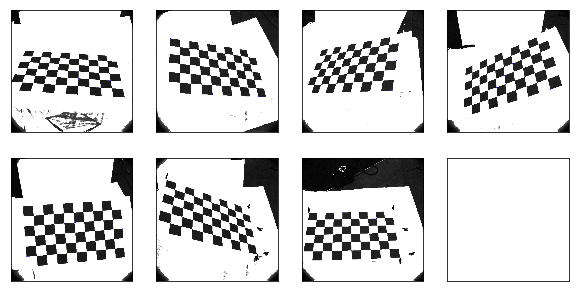

In [32]:
import numpy as np
import cv2
import glob
import os
from PIL import Image
import urllib.request as ul
import matplotlib
import matplotlib.pyplot as plt
import itertools

img_files = glob.glob('tp2-data/*.png')
print('Number of damier:', len(img_files))

plt_nrow = 2
plt_ncol = 4
fig, ax = plt.subplots(plt_nrow, plt_ncol,figsize=(10, 5))
for i, j in itertools.product(range(plt_nrow), range(plt_ncol)):
    ax[i, j].get_xaxis().set_visible(False)
    ax[i, j].get_yaxis().set_visible(False)

for k, fn in enumerate(img_files):
    i = k // 4
    j = k % 4
    ax[i, j].cla()
    img = cv2.imread(fn,1)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ax[i, j].imshow(img)
plt.show()

2. trouver le damier dans chaque image, afficher les coordonnés

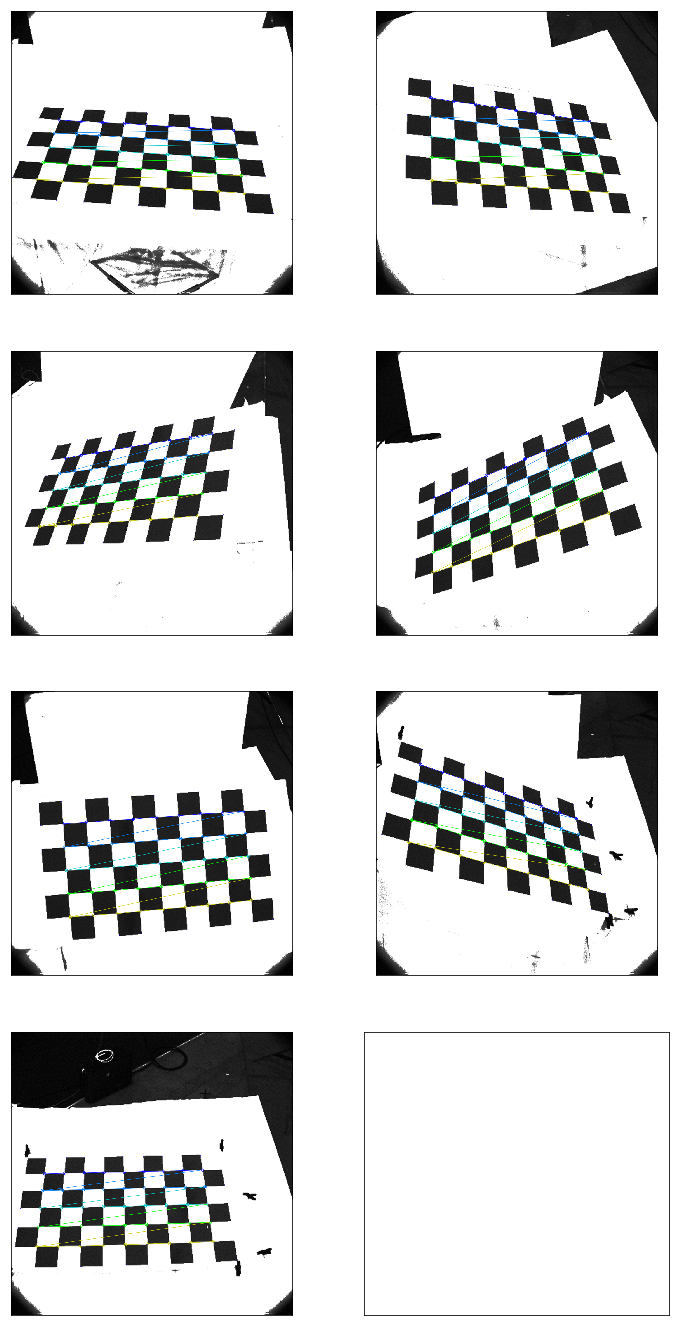

In [35]:
#w = 1008;h = 1016;
Img_size=cv2.imread(img_files[0],0).shape[::-1]
# interne corner nubmer, patternSize = cvSize(points_per_row,points_per_colum)= cvSize(columns,rows)
Damier_size = (9, 5)
square_size = 12.6 #1
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
damier_points = np.zeros((Damier_size[0]*Damier_size[1], 3), np.float32)
# get shape=row x col x coordonee matrix
damier_points[:, :2] = np.mgrid[0:Damier_size[0], 0:Damier_size[1]].T.reshape(-1, 2)
damier_points=damier_points*square_size

# Arrays to store object points and image points from all the images.
all_damiers_points = []  # 3d points in real world space
all_imgs_points = []  # 2d points in image plane.

plt_nrow = 4
plt_ncol = 2
fig, ax = plt.subplots(plt_nrow, plt_ncol,figsize=(12, 24))
for i, j in itertools.product(range(plt_nrow), range(plt_ncol)):
    ax[i, j].get_xaxis().set_visible(False)
    ax[i, j].get_yaxis().set_visible(False)
    
for k,fname in enumerate(img_files):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    found, corners = cv2.findChessboardCorners(gray, Damier_size, None)
    # If found, add object points, image points (after refining them)
    if found:
        all_damiers_points.append(damier_points)
        # Refines the corner locations (more accurate)
        corners = cv2.cornerSubPix(
            gray, corners, (8, 8), (-1, -1), criteria)
        all_imgs_points.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, Damier_size, corners, found)
        
        i = k // 2
        j = k % 2
        ax[i, j].cla()
        ax[i, j].imshow(img)
        
plt.show()

3. calibrer la caméra par homographie, afficher la matrice trouvée

In [17]:
ret, camera_M, dist, rvecs, tvecs = cv2.calibrateCamera(
    all_damiers_points, all_imgs_points, Img_size, None, None)
    
np.set_printoptions(suppress=True)
print('F Matrix:\n', camera_M)

F Matrix:
 [[1476.77757048    0.          522.260852  ]
 [   0.         1477.29350287  515.09570869]
 [   0.            0.            1.        ]]


In [ ]:
for i in range(len(img_files)):
    print(i,'th Translation:\n',tvecs[i])

# Convert rvec to 3x3 Rotation matrix
rotationMats = [cv2.Rodrigues(rvec)[0] for rvec in rvecs]
for i in range(len(img_files)):
    print(i,'th Rotation:\n',rotationMats[i])

4. l'erreur de reprojection en pixel.

In [13]:
#Re-projection Error
mean_error = 0
for i in range(len(img_files)):
    imgpoints2, _ = cv2.projectPoints(all_damiers_points[i], rvecs[i], tvecs[i], camera_M, dist)
    error = cv2.norm(all_imgs_points[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(img_files)) )

total error: 0.11224848578743975


5. Si la matrice ne corresponds pas à celle que vous avez trouvé, expliquez pourquoi à votre avis.

C'est le F Matrice de la camera que J'ai trouvé dans Mathematica pour la partie 5:

| 1495.9 | 0      | 462.1 |
|--------|--------|-------|
| 0      | 1495.9 | 567.1 |
| 0      | 0      | 1     |

C'est celle de OpenCV ici:

| 1476.8 | 0      | 522.3 |
|--------|--------|-------|
| 0      | 1477.3 | 515.1 |
| 0      | 0      | 1     |

À mon avois, les deux matrice de camera sont assez proche, mais les points ici sont trouvé automatiquement par Opencv, et pour chaque damier ici, il y a seulement 9x5=45 points, moins que 75 points qu'on utilise dans Mathematica. Donc la matrice de camera ici est probablement un peu plus mauvais que celle dans Mathematica.